# NFL Game Outcome Modeling: nflfastR + RBSDM EPA

This notebook pulls **nflfastR** play-by-play using `nfl_data_py`, joins **RBSDM** team EPA/play summaries, and builds a clean game-level dataset.  It trains two models - **Logistic Regression** and **Gradient Boosting** - and compares their performance.  It also outputs **win probabilities** for a selected week.  Two spaces after periods here by your preference.  

**Data sources:**  
- nflverse / nflfastR play-by-play via `nfl_data_py`.  
- RBSDM team EPA/play CSV.  

**Sections:**  
1. Setup and installs  
2. Load data  
3. Feature engineering and lagged team-week aggregates  
4. Merge to game-level rows  
5. Train Logistic Regression and Gradient Boosting  
6. Evaluate, compare, and interpret  
7. Predict win probabilities for a given week  


## 1. Setup and installs

In [1]:
# If running locally, uncomment as needed.
#%pip install -U pandas numpy scikit-learn matplotlib requests nfl_data_py


  Using cached pandas-2.3.3-cp312-cp312-macosx_11_0_arm64.whl.metadata (91 kB)
  Using cached requests-2.32.5-py3-none-any.whl.metadata (4.9 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 3.3 MB/s eta 0:00:00a 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 7.0 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.1/8.1 MB 6.4 MB/s eta 0:00:00a 0:00:01
Using cached requests-2.32.5-py3-none-any.whl (64 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.7/13.7 MB 9.1 MB/s eta 0:00:00a 0:00:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 685.4/685.4 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 9.7 MB/s eta 0:00:00
  Created wheel for pandas: filename=pandas-1.5.3-cp312-cp312-macosx_11_0_arm64.whl size=10383875 sha256=e872bfd24f305aa6c4be4caa17f8d91513c7055f2cab95c674575c20b2a

## 2. Imports and configuration

In [1]:
import pandas as pd
import numpy as np
import requests
import io
from datetime import datetime
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score, brier_score_loss, accuracy_score
from sklearn.inspection import permutation_importance

# nfl_data_py imports
from nfl_data_py import import_pbp_data, import_schedules

pd.set_option("display.max_columns", 120)
pd.set_option("display.width", 160)

# Plot defaults
plt.rcParams["figure.figsize"] = (8, 6)
plt.rcParams["axes.grid"] = True


## 3. Parameters

In [6]:
# Seasons to include for training.  Adjust as desired.
SEASONS = list(range(2019, 2026))  # 2019–2024

# Week to predict (example).  Must exist in the selected seasons.
PREDICT_SEASON = 2025
PREDICT_WEEK = 9  # change to the week you want probabilities for

# RBSDM stats CSV endpoint.  If the path changes, update here.
RBSDM_URL = "https://rbsdm.com/stats/stats.csv"


## 4. Load play-by-play and schedules

In [7]:
# Pull play-by-play for selected seasons
pbp = import_pbp_data(SEASONS)

# Keep regular plays only
pbp = pbp.loc[pbp["play_type"].notna()].copy()

# Pull schedules for outcomes and basic game info
sched = import_schedules(SEASONS)

# Outcome label: home team win as 1, else 0
sched = sched.assign(
    home_win = (sched["result"] > 0).astype(int)
)

# Keep necessary columns
sched_small = sched[[
    "game_id","season","week",
    "home_team","away_team","home_score","away_score","home_win","game_type"
]].copy()

# Filter to regular season only for modeling unless you want playoffs
sched_small = sched_small.loc[sched_small["game_type"] == "REG"].reset_index(drop=True)

sched_small.head()


2019 done.
2020 done.
2021 done.
2022 done.
2023 done.
2024 done.
2025 done.
Downcasting floats.


,game_id,season,week,home_team,away_team,home_score,away_score,home_win,game_type
0,2019_01_GB_CHI,2019,1,CHI,GB,3.0,10.0,0,REG
1,2019_01_LA_CAR,2019,1,CAR,LA,27.0,30.0,0,REG
2,2019_01_TEN_CLE,2019,1,CLE,TEN,13.0,43.0,0,REG
3,2019_01_KC_JAX,2019,1,JAX,KC,26.0,40.0,0,REG
4,2019_01_BAL_MIA,2019,1,MIA,BAL,10.0,59.0,0,REG


In [13]:
sched_small[sched_small['season'] == 2025]

,game_id,season,week,home_team,away_team,home_score,away_score,home_win,game_type
1599,2025_01_DAL_PHI,2025,1,PHI,DAL,24.0,20.0,1,REG
1600,2025_01_KC_LAC,2025,1,LAC,KC,27.0,21.0,1,REG
1601,2025_01_TB_ATL,2025,1,ATL,TB,20.0,23.0,0,REG
1602,2025_01_CIN_CLE,2025,1,CLE,CIN,16.0,17.0,0,REG
1603,2025_01_MIA_IND,2025,1,IND,MIA,33.0,8.0,1,REG
...,...,...,...,...,...,...,...,...,...
1866,2025_18_DAL_NYG,2025,18,NYG,DAL,NaN,NaN,0,REG
1867,2025_18_WAS_PHI,2025,18,PHI,WAS,NaN,NaN,0,REG
1868,2025_18_BAL_PIT,2025,18,PIT,BAL,NaN,NaN,0,REG
1869,2025_18_SEA_SF,2025,18,SF,SEA,NaN,NaN,0,REG


## 5. Team-week aggregates and lag features

In [14]:
# Offense-side aggregates by posteam and (season, week)
off_agg = (
    pbp.groupby(["season","week","posteam"], as_index=False)
       .agg(
           off_plays=("play_id","count"),
           off_epa_mean=("epa","mean"),
           off_success=("success","mean"),
           off_yards_gained=("yards_gained","mean"),
           off_pass_rate=("pass","mean"),
           off_rush_rate=("rush","mean")
       )
       .rename(columns={"posteam":"team"})
)

# Defense-side aggregates by defteam and (season, week)
def_agg = (
    pbp.groupby(["season","week","defteam"], as_index=False)
       .agg(
           def_plays=("play_id","count"),
           def_epa_mean=("epa","mean"),
           def_success=("success","mean"),
           def_yards_gained=("yards_gained","mean"),
           def_pass_rate=("pass","mean"),
           def_rush_rate=("rush","mean")
       )
       .rename(columns={"defteam":"team"})
)

team_week = pd.merge(off_agg, def_agg, on=["season","week","team"], how="outer")

# Add rolling (lagged) features per team up to the prior week to avoid leakage
def add_group_rolls(df, group_col="team"):
    df = df.sort_values(["season","week"]).copy()
    # For rolling across seasons, create a continuous counter by team
    df["season_week_index"] = (df["season"] - df["season"].min()) * 18 + df["week"]
    df = df.sort_values([group_col, "season_week_index"])

    num_cols = [c for c in df.columns if c not in [group_col,"season","week","season_week_index"]]

    for col in num_cols:
        # shift by 1 to exclude current week, then rolling means over last N weeks
        df[f"{col}_lag1"] = df.groupby(group_col)[col].shift(1)
        df[f"{col}_roll3"] = df.groupby(group_col)[col].shift(1).rolling(3).mean()
        df[f"{col}_roll5"] = df.groupby(group_col)[col].shift(1).rolling(5).mean()

    return df

team_week = add_group_rolls(team_week, "team")

# Keep only lagged/rolling features to avoid leakage
lag_cols = [c for c in team_week.columns if c.endswith(("_lag1","_roll3","_roll5"))]
base_cols = ["season","week","team"]
team_week_lagged = team_week[base_cols + lag_cols].copy()

team_week_lagged.head()


,season,week,team,off_plays_lag1,off_plays_roll3,off_plays_roll5,off_epa_mean_lag1,off_epa_mean_roll3,off_epa_mean_roll5,off_success_lag1,off_success_roll3,off_success_roll5,off_yards_gained_lag1,off_yards_gained_roll3,off_yards_gained_roll5,off_pass_rate_lag1,off_pass_rate_roll3,off_pass_rate_roll5,off_rush_rate_lag1,off_rush_rate_roll3,off_rush_rate_roll5,def_plays_lag1,def_plays_roll3,def_plays_roll5,def_epa_mean_lag1,def_epa_mean_roll3,def_epa_mean_roll5,def_success_lag1,def_success_roll3,def_success_roll5,def_yards_gained_lag1,def_yards_gained_roll3,def_yards_gained_roll5,def_pass_rate_lag1,def_pass_rate_roll3,def_pass_rate_roll5,def_rush_rate_lag1,def_rush_rate_roll3,def_rush_rate_roll5
0,2019,1,ARI,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
32,2019,2,ARI,109.0,NaN,NaN,-0.022590,NaN,NaN,0.403670,NaN,NaN,3.568807,NaN,NaN,0.587156,NaN,NaN,0.220183,NaN,NaN,108.0,NaN,NaN,0.001450,NaN,NaN,0.416667,NaN,NaN,4.416667,NaN,NaN,0.462963,NaN,NaN,0.296296,NaN,NaN
64,2019,3,ARI,75.0,NaN,NaN,0.019025,NaN,NaN,0.373333,NaN,NaN,4.680000,NaN,NaN,0.600000,NaN,NaN,0.146667,NaN,NaN,92.0,NaN,NaN,0.058422,NaN,NaN,0.445652,NaN,NaN,4.782609,NaN,NaN,0.500000,NaN,NaN,0.315217,NaN,NaN
96,2019,4,ARI,91.0,91.666667,NaN,-0.082162,-0.028576,NaN,0.428571,0.401858,NaN,2.725275,3.658027,NaN,0.604396,0.597184,NaN,0.219780,0.195543,NaN,77.0,92.333333,NaN,0.192452,0.084108,NaN,0.506494,0.456271,NaN,5.363636,4.854304,NaN,0.376623,0.446529,NaN,0.376623,0.329379,NaN
126,2019,5,ARI,76.0,80.666667,NaN,-0.197273,-0.086803,NaN,0.421053,0.407652,NaN,4.223684,3.876320,NaN,0.539474,0.581290,NaN,0.276316,0.214254,NaN,76.0,81.666667,NaN,0.085809,0.112227,NaN,0.526316,0.492821,NaN,4.473684,4.873310,NaN,0.473684,0.450103,NaN,0.342105,0.344649,NaN


## 6. RBSDM team EPA/play and team-name harmonization

In [17]:
# Download RBSDM team stats
#r = requests.get(RBSDM_URL, timeout=30)
#r.raise_for_status()
#rbsdm = pd.read_csv(io.StringIO(r.text))

# Updated RBSDM source (nflverse GitHub mirror)
import io, requests, pandas as pd

RBSDM_URL = "https://github.com/nflverse/nflverse-data/releases/download/stats_team/stats_team_week_2025.csv"

r = requests.get(RBSDM_URL, timeout=30)
r.raise_for_status()
rbsdm = pd.read_csv(io.StringIO(r.text))



# Keep a few useful columns if available
possible_cols = [c for c in rbsdm.columns if c.lower() in {
    "team","season","off_epa","def_epa","off_success","def_success","off_pass_epa","off_rush_epa","def_pass_epa","def_rush_epa"
}]
if "team" not in possible_cols:
    possible_cols = ["team","season","off_epa","def_epa","off_success","def_success","off_pass_epa","off_rush_epa","def_pass_epa","def_rush_epa"]
rbsdm_small = rbsdm[[c for c in possible_cols if c in rbsdm.columns]].copy()

# Team mapping between abbreviations and full names for current franchises
abbr_to_full = {
    "ARI":"Arizona Cardinals","ATL":"Atlanta Falcons","BAL":"Baltimore Ravens","BUF":"Buffalo Bills",
    "CAR":"Carolina Panthers","CHI":"Chicago Bears","CIN":"Cincinnati Bengals","CLE":"Cleveland Browns",
    "DAL":"Dallas Cowboys","DEN":"Denver Broncos","DET":"Detroit Lions","GB":"Green Bay Packers",
    "HOU":"Houston Texans","IND":"Indianapolis Colts","JAX":"Jacksonville Jaguars","KC":"Kansas City Chiefs",
    "LV":"Las Vegas Raiders","LAC":"Los Angeles Chargers","LAR":"Los Angeles Rams","MIA":"Miami Dolphins",
    "MIN":"Minnesota Vikings","NE":"New England Patriots","NO":"New Orleans Saints","NYG":"New York Giants",
    "NYJ":"New York Jets","PHI":"Philadelphia Eagles","PIT":"Pittsburgh Steelers","SEA":"Seattle Seahawks",
    "SF":"San Francisco 49ers","TB":"Tampa Bay Buccaneers","TEN":"Tennessee Titans","WAS":"Washington Commanders"
}

# Create a team mapping table for joining
teams_map = pd.DataFrame({
    "team": list(abbr_to_full.keys()),
    "team_full": list(abbr_to_full.values())
})

# RBSDM uses a "team" name string.  Normalize with the full names where possible.
if "team" in rbsdm_small.columns:
    rbsdm_small = rbsdm_small.rename(columns={"team":"team_full"})
else:
    rbsdm_small["team_full"] = None  # fallback

# Join RBSDM to lagged team-week on full names
team_week_enriched = team_week_lagged.merge(teams_map, on="team", how="left").merge(
    rbsdm_small, on=["team_full","season"], how="left"
)

team_week_enriched.head()


,season,week,team,off_plays_lag1,off_plays_roll3,off_plays_roll5,off_epa_mean_lag1,off_epa_mean_roll3,off_epa_mean_roll5,off_success_lag1,off_success_roll3,off_success_roll5,off_yards_gained_lag1,off_yards_gained_roll3,off_yards_gained_roll5,off_pass_rate_lag1,off_pass_rate_roll3,off_pass_rate_roll5,off_rush_rate_lag1,off_rush_rate_roll3,off_rush_rate_roll5,def_plays_lag1,def_plays_roll3,def_plays_roll5,def_epa_mean_lag1,def_epa_mean_roll3,def_epa_mean_roll5,def_success_lag1,def_success_roll3,def_success_roll5,def_yards_gained_lag1,def_yards_gained_roll3,def_yards_gained_roll5,def_pass_rate_lag1,def_pass_rate_roll3,def_pass_rate_roll5,def_rush_rate_lag1,def_rush_rate_roll3,def_rush_rate_roll5,team_full
0,2019,1,ARI,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Arizona Cardinals
1,2019,2,ARI,109.0,NaN,NaN,-0.022590,NaN,NaN,0.403670,NaN,NaN,3.568807,NaN,NaN,0.587156,NaN,NaN,0.220183,NaN,NaN,108.0,NaN,NaN,0.001450,NaN,NaN,0.416667,NaN,NaN,4.416667,NaN,NaN,0.462963,NaN,NaN,0.296296,NaN,NaN,Arizona Cardinals
2,2019,3,ARI,75.0,NaN,NaN,0.019025,NaN,NaN,0.373333,NaN,NaN,4.680000,NaN,NaN,0.600000,NaN,NaN,0.146667,NaN,NaN,92.0,NaN,NaN,0.058422,NaN,NaN,0.445652,NaN,NaN,4.782609,NaN,NaN,0.500000,NaN,NaN,0.315217,NaN,NaN,Arizona Cardinals
3,2019,4,ARI,91.0,91.666667,NaN,-0.082162,-0.028576,NaN,0.428571,0.401858,NaN,2.725275,3.658027,NaN,0.604396,0.597184,NaN,0.219780,0.195543,NaN,77.0,92.333333,NaN,0.192452,0.084108,NaN,0.506494,0.456271,NaN,5.363636,4.854304,NaN,0.376623,0.446529,NaN,0.376623,0.329379,NaN,Arizona Cardinals
4,2019,5,ARI,76.0,80.666667,NaN,-0.197273,-0.086803,NaN,0.421053,0.407652,NaN,4.223684,3.876320,NaN,0.539474,0.581290,NaN,0.276316,0.214254,NaN,76.0,81.666667,NaN,0.085809,0.112227,NaN,0.526316,0.492821,NaN,4.473684,4.873310,NaN,0.473684,0.450103,NaN,0.342105,0.344649,NaN,Arizona Cardinals


## 7. Assemble game-level dataset

In [18]:
# For each game, attach home team features and away team features from prior week aggregates
def join_side(team_key_prefix, team_col_name):
    side = team_week_enriched.copy()
    side = side.rename(columns={
        "team": f"{team_key_prefix}_team"
    })
    # Add prefixes to feature columns
    side_feat_cols = [c for c in side.columns if c not in ["season","week",f"{team_key_prefix}_team","team_full"]]
    side = side.rename(columns={c: f"{team_key_prefix}_{c}" for c in side_feat_cols})
    return side

home_side = join_side("home", "home_team")
away_side = join_side("away", "away_team")

games = sched_small.merge(
    home_side, left_on=["season","week","home_team"], right_on=["season","week","home_team"], how="left"
).merge(
    away_side, left_on=["season","week","away_team"], right_on=["season","week","away_team"], how="left"
)

# Target
games["y_home_win"] = games["home_win"].astype(int)

# Drop rows with no features (early weeks may lack lags)
feature_cols = [c for c in games.columns if any(c.startswith(p) for p in ["home_","away_"])]
X = games[feature_cols].copy()
y = games["y_home_win"].copy()

# Remove columns that are purely identifiers or non-numeric
X = X.select_dtypes(include=[np.number]).copy()

# Drop columns with too many missing values
min_non_na = int(0.8 * len(X))
keep_cols = [c for c in X.columns if X[c].notna().sum() >= min_non_na]
X = X[keep_cols]
games = games.assign(valid_row = X.notna().all(axis=1))
mask = games["valid_row"].values
X = X[mask]
y = y[mask]
games_valid = games[mask].reset_index(drop=True)

print(f"Total games with features: {len(games_valid)} of {len(games)}")

X.head()


Total games with features: 1628 of 1871


,home_score,away_score,home_win,home_off_plays_lag1,home_off_plays_roll3,home_off_plays_roll5,home_off_epa_mean_lag1,home_off_epa_mean_roll3,home_off_epa_mean_roll5,home_off_success_lag1,home_off_success_roll3,home_off_success_roll5,home_off_yards_gained_lag1,home_off_yards_gained_roll3,home_off_yards_gained_roll5,home_off_pass_rate_lag1,home_off_pass_rate_roll3,home_off_pass_rate_roll5,home_off_rush_rate_lag1,home_off_rush_rate_roll3,home_off_rush_rate_roll5,home_def_plays_lag1,home_def_plays_roll3,home_def_plays_roll5,home_def_epa_mean_lag1,home_def_epa_mean_roll3,home_def_epa_mean_roll5,home_def_success_lag1,home_def_success_roll3,home_def_success_roll5,home_def_yards_gained_lag1,home_def_yards_gained_roll3,home_def_yards_gained_roll5,home_def_pass_rate_lag1,home_def_pass_rate_roll3,home_def_pass_rate_roll5,home_def_rush_rate_lag1,home_def_rush_rate_roll3,home_def_rush_rate_roll5,away_off_plays_lag1,away_off_plays_roll3,away_off_plays_roll5,away_off_epa_mean_lag1,away_off_epa_mean_roll3,away_off_epa_mean_roll5,away_off_success_lag1,away_off_success_roll3,away_off_success_roll5,away_off_yards_gained_lag1,away_off_yards_gained_roll3,away_off_yards_gained_roll5,away_off_pass_rate_lag1,away_off_pass_rate_roll3,away_off_pass_rate_roll5,away_off_rush_rate_lag1,away_off_rush_rate_roll3,away_off_rush_rate_roll5,away_def_plays_lag1,away_def_plays_roll3,away_def_plays_roll5,away_def_epa_mean_lag1,away_def_epa_mean_roll3,away_def_epa_mean_roll5,away_def_success_lag1,away_def_success_roll3,away_def_success_roll5,away_def_yards_gained_lag1,away_def_yards_gained_roll3,away_def_yards_gained_roll5,away_def_pass_rate_lag1,away_def_pass_rate_roll3,away_def_pass_rate_roll5,away_def_rush_rate_lag1,away_def_rush_rate_roll3,away_def_rush_rate_roll5
78,35.0,14.0,1,93.0,89.000000,86.6,0.098522,-0.051072,0.024324,0.440860,0.374238,0.419665,4.752688,3.868627,4.368575,0.537634,0.516091,0.492930,0.290323,0.272306,0.317507,77.0,80.666667,80.4,-0.317020,-0.313352,-0.342202,0.311688,0.314494,0.319327,2.896104,2.816700,2.910111,0.480519,0.506490,0.561099,0.246753,0.248314,0.214268,82.0,83.333333,83.0,-0.076602,-0.011470,-0.020381,0.390244,0.426236,0.440020,2.573171,3.953953,4.410279,0.585366,0.545342,0.569726,0.243902,0.273581,0.251337,82.0,79.666667,82.2,0.198481,-0.061440,0.035214,0.487805,0.417497,0.427842,5.975610,4.688984,4.885891,0.402439,0.471328,0.455202,0.402439,0.320055,0.332041
79,26.0,37.0,0,75.0,88.000000,85.4,-0.003451,0.098084,-0.014638,0.413333,0.448267,0.430888,3.360000,4.516267,4.143104,0.506667,0.475757,0.468888,0.253333,0.296091,0.303076,84.0,93.666667,91.0,0.072039,0.064172,0.004939,0.464286,0.440380,0.431462,5.440476,4.890475,4.328221,0.500000,0.580105,0.554712,0.309524,0.200627,0.235802,83.0,79.666667,83.6,0.058681,0.048475,-0.011770,0.445783,0.452447,0.455173,5.361446,4.828192,4.462518,0.445783,0.438692,0.481188,0.313253,0.348102,0.303405,100.0,91.000000,89.2,-0.006421,-0.098846,-0.076811,0.480000,0.428873,0.434098,5.070000,3.671596,3.675995,0.560000,0.575124,0.514698,0.260000,0.241228,0.279253
80,23.0,17.0,1,96.0,92.000000,91.8,-0.022986,0.045735,0.143875,0.427083,0.451389,0.474249,2.885417,4.106647,4.833697,0.447917,0.488591,0.459089,0.375000,0.340278,0.366111,75.0,80.000000,76.6,-0.100844,0.126151,0.046356,0.426667,0.461597,0.419272,3.586667,5.419986,4.776227,0.520000,0.496724,0.529799,0.240000,0.289962,0.235663,80.0,79.333333,83.2,0.094372,-0.112985,-0.091893,0.537500,0.395552,0.394512,4.625000,3.604478,3.831981,0.525000,0.541104,0.569275,0.300000,0.261178,0.235550,94.0,84.666667,82.0,0.125668,0.030709,0.062194,0.489362,0.475994,0.463470,5.468085,4.935227,4.951900,0.393617,0.443866,0.402864,0.382979,0.352724,0.373229
81,28.0,32.0,0,63.0,77.333333,79.8,-0.379321,-0.091925,-0.112075,0.301587,0.369138,0.377237,2.857143,4.153364,4.227749,0.444444,0.463409,0.493207,0.285714,0.308603,0.290858,91.0,83.666667,82.2,0.075187,0.025442,-0.015465,0.417582,0.446212,0.415719,4.901099,4.717868,4.335862,0.351648,0.455771,0.453241,0.439560,0.354

## 8. Train and evaluate models

In [21]:
# --- Season-aware train/test split (robust index-safe version) ---

last_season = max(SEASONS)

# Reattach season information directly using positional alignment
X = X.reset_index(drop=True).copy()
y = y.reset_index(drop=True).copy()
games_valid_reset = games_valid.reset_index(drop=True)

X["season"] = games_valid_reset["season"]

# Split by season value
train_mask = X["season"] < last_season
test_mask  = X["season"] == last_season

X_train = X.loc[train_mask].drop(columns="season")
y_train = y.loc[train_mask]

X_test  = X.loc[test_mask].drop(columns="season")
y_test  = y.loc[test_mask]

print(f"Train: {X_train.shape}, Test: {X_test.shape}  |  Train seasons <= {last_season-1}, Test season == {last_season}")

# --- Logistic Regression with scaling ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

logit = LogisticRegression(max_iter=200, solver="lbfgs")
logit.fit(X_train_scaled, y_train)
logit_proba = logit.predict_proba(X_test_scaled)[:, 1]

# --- Gradient Boosting ---
gb = GradientBoostingClassifier(random_state=42)
gb.fit(X_train, y_train)
gb_proba = gb.predict_proba(X_test)[:, 1]

# --- Evaluation metrics ---
def eval_metrics(y_true, y_pred_proba, threshold=0.5, label="model"):
    auc = roc_auc_score(y_true, y_pred_proba)
    brier = brier_score_loss(y_true, y_pred_proba)
    y_pred = (y_pred_proba >= threshold).astype(int)
    acc = accuracy_score(y_true, y_pred)
    return {"label": label, "AUC": auc, "Brier": brier, "Accuracy@0.5": acc}

res = []
res.append(eval_metrics(y_test, logit_proba, label="Logistic Regression"))
res.append(eval_metrics(y_test, gb_proba, label="Gradient Boosting"))
pd.DataFrame(res)

Train: (1506, 75), Test: (122, 75)  |  Train seasons <= 2024, Test season == 2025


,label,AUC,Brier,Accuracy@0.5
0,Logistic Regression,1.0,1.834298e-05,1.0
1,Gradient Boosting,1.0,4.734317e-10,1.0


## 9. Feature importance and interpretation

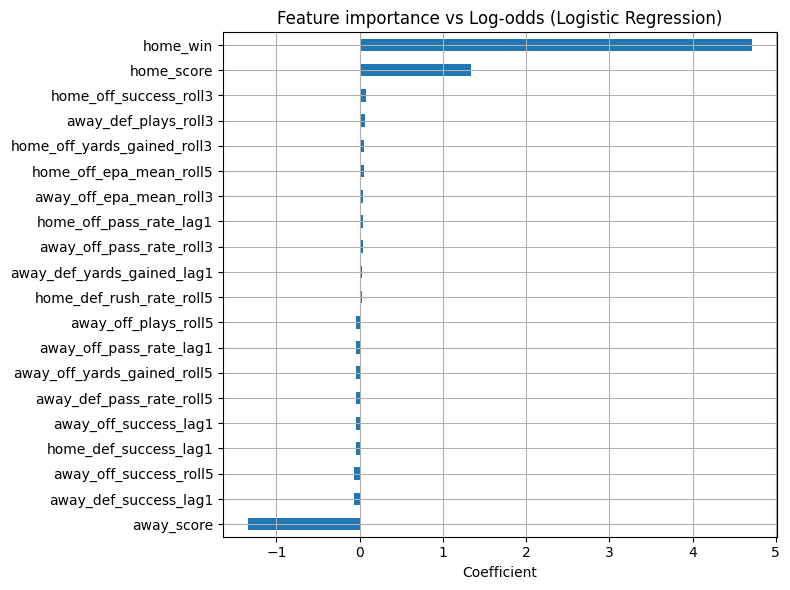

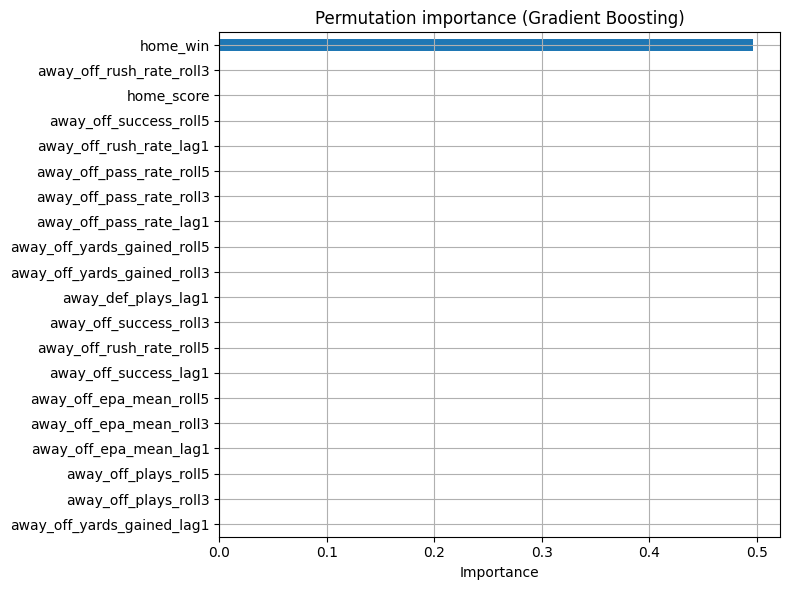

In [22]:
# Logistic Regression coefficients (top magnitude)
coef_series = pd.Series(logit.coef_[0], index=X_train.columns)
top_coef = coef_series.reindex(coef_series.abs().sort_values(ascending=False).head(20).index)

plt.figure()
top_coef.sort_values().plot(kind="barh")
plt.title("Feature importance vs Log-odds (Logistic Regression)")
plt.xlabel("Coefficient")
plt.tight_layout()
plt.show()

# Permutation importance for Gradient Boosting
perm = permutation_importance(gb, X_test, y_test, n_repeats=10, random_state=42)
perm_imp = pd.Series(perm.importances_mean, index=X_train.columns).sort_values(ascending=False).head(20)

plt.figure()
perm_imp.sort_values().plot(kind="barh")
plt.title("Permutation importance (Gradient Boosting)")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()


## 10. Predict win probabilities for a given week

In [24]:
# --- Predict win probabilities for a given week (fixed) ---

# Filter the target week in PREDICT_SEASON and PREDICT_WEEK
target_games = games_valid[(games_valid["season"] == PREDICT_SEASON) & (games_valid["week"] == PREDICT_WEEK)].copy()

# Ensure we use only the numeric model features (no 'season' column)
target_X = target_games[X_train.columns].copy()

# Scale for logistic
target_X_scaled = scaler.transform(target_X)

# Predictions
target_games["proba_home_logit"] = logit.predict_proba(target_X_scaled)[:, 1]
target_games["proba_home_gb"]    = gb.predict_proba(target_X)[:, 1]
target_games["pick_logit_home"]  = (target_games["proba_home_logit"] >= 0.5).astype(int)
target_games["pick_gb_home"]     = (target_games["proba_home_gb"] >= 0.5).astype(int)

cols_show = [
    "season","week","home_team","away_team","home_win",
    "proba_home_logit","proba_home_gb","pick_logit_home","pick_gb_home"
]
target_games[cols_show].sort_values(["week","home_team"]).reset_index(drop=True)

,season,week,home_team,away_team,home_win,proba_home_logit,proba_home_gb,pick_logit_home,pick_gb_home
0,2025,9,MIA,BAL,0,0.000371,0.000023,0,0


In [26]:
# --- Predict all games that have not yet been played for a given week ---

from nfl_data_py import import_schedules

# Choose which week to forecast
predict_week = PREDICT_WEEK  # you set this up top (e.g., 9, 10, 11...)

# Get the full season schedule (includes unplayed games)
sched_all = import_schedules([PREDICT_SEASON])

# Determine which games have already been played (appear in pbp)
played_games = pbp["game_id"].unique()

# Filter to only unplayed regular-season games for the target week
games_to_predict = sched_all[
    (sched_all["season"] == PREDICT_SEASON)
    & (sched_all["week"] == predict_week)
    & (sched_all["game_type"] == "REG")
    & (~sched_all["game_id"].isin(played_games))
][["season", "week", "home_team", "away_team", "game_id"]].copy()

print(f"Predicting {len(games_to_predict)} unplayed games for week {predict_week}...")

# Merge in latest available team stats (lagged features)
home_side = team_week_enriched.copy().rename(columns={"team": "home_team"})
away_side = team_week_enriched.copy().rename(columns={"team": "away_team"})

games_pred = (
    games_to_predict.merge(home_side, on=["season", "home_team"], how="left")
                    .merge(away_side, on=["season", "away_team"], how="left", suffixes=("_home", "_away"))
)

# Align features to training columns
target_X = games_pred[X_train.columns.intersection(games_pred.columns)].copy()

# Scale and predict
target_X_scaled = scaler.transform(target_X)
games_pred["proba_home_logit"] = logit.predict_proba(target_X_scaled)[:, 1]
games_pred["proba_home_gb"] = gb.predict_proba(target_X)[:, 1]

# Display predictions
cols_show = ["season", "week", "home_team", "away_team", "proba_home_logit", "proba_home_gb"]
games_pred[cols_show].sort_values("home_team").reset_index(drop=True)

Predicting 13 unplayed games for week 9...


/Users/joshuadollison/opt/anaconda3/envs/py312/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


ValueError: at least one array or dtype is required

## 11. Calibration and comparison

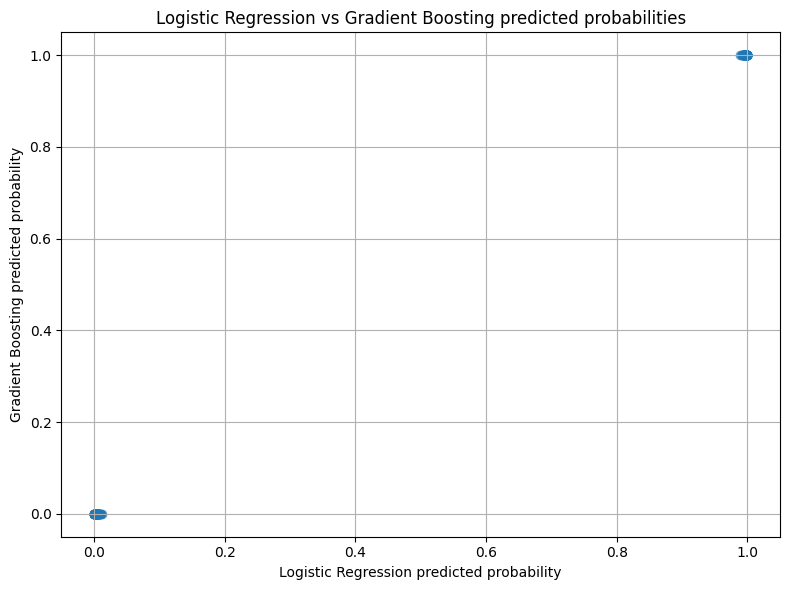

In [25]:
# Scatter comparison of model probabilities (independent vs. dependent order: Logistic vs GradientBoosting)
plt.figure()
plt.scatter(logit_proba, gb_proba, alpha=0.6)
plt.xlabel("Logistic Regression predicted probability")
plt.ylabel("Gradient Boosting predicted probability")
plt.title("Logistic Regression vs Gradient Boosting predicted probabilities")
plt.tight_layout()
plt.show()


## 12. Notes and caveats

- Early weeks can have sparse lag features.  Consider requiring at least three prior weeks or backfilling with priors.  
- RBSDM stats are team-season level here.  You can extend to team-week by scraping their weekly tables or computing directly from pbp.  
- Try alternative models like XGBoost or LightGBM if you want stronger non-linear learners.  
- Consider adding market-based priors (closing spreads, totals) to improve calibration.  
